## Airline passenger load forecasting using time series prediction

## Motivation

Forecasting air passenger demand is a critical aspect of formulating appropriate operation plans in airport operation. Airport operation not only requires long-term demand forecasting to establish long-term plans, but also short-term demand forecasting for more immediate concerns. Most airports forecast their short-term passenger demand based on experience, which provides limited forecasting accuracy, depending on the level of expertise. For accurate short-term forecasting independent of the level of expertise, it is necessary to create reliable short-term forecasting models and to reflect short-term fluctuations in air passenger demand. (Cite 1) 

## Problem Statment

The problem is to predict the passenger count for future months given a history of passenger loan from 1949-1960. This dataset provides monthly totals of a US airline passengers from 1949 to 1960. This dataset is taken from an inbuilt dataset of R called AirPassengers.



## Aim of the project

The aim of the project is to assist airline,investors and other stakeholders in the Airlines industry to be able to decide based on insights drawn from the predictions. The project will demonestrate the use of a machine learning subdomain called **Aritificial Nueral Network** to solve the above problem. The NN we used is **Recurrent Neural Network**. A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. (Cite 2)

## Import libraries

In [75]:
import numpy
import matplotlib.pyplot as plt
import pandas
import statsmodels.api as sm

## Download the data 

The dataset used in this project is publicly available in kaggle dataset called Air Passengers by Chirag Kothari. It consists of monthly totals of a US airline passengers from 1949 to 1960. 


### Download the data using kaggle api

We can directly download the dataset and upload it to our workspace. But that is inefficient when if the dataset is large. We an use kaggle's api to directly download any dataset found in kaggle. 

In [2]:
!pip install -q kaggle

In [6]:
!ls

airlines-demand-forecasting-LSTM.ipynb	       kaggle.json
airlines-demand-forecasting-lstm.ipynb.amltmp


In [10]:
 !mkdir ~/.kaggle

In [11]:
! cp kaggle.json ~/.kaggle/

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-26 21:13:45           6127        557  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3447        298  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1224        106  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset             

In [14]:
!kaggle datasets download -d chirag19/air-passengers

  0%|                                                 | 0.00/764 [00:00<?, ?B/s]
100%|██████████████████████████████████████████| 764/764 [00:00<00:00, 8.80kB/s]


In [16]:
!unzip ./air-passengers.zip

Archive:  ./air-passengers.zip
  inflating: AirPassengers.csv       


## Explore Data

Now that we have downloaded the data we can see what it looks like using libraries like Pandas and Matplotlib.

In [25]:
df = pandas.read_csv('AirPassengers.csv', engine='python')
# dataset = dataframe.values
# dataset = dataset.astype('float32')

In [26]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [27]:
df.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [31]:
df.count()

Month          144
#Passengers    144
dtype: int64

In [34]:
df.describe()


,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


From the start we can see that "#passengers" is not a good name for a column. Let's rename that

In [50]:
df.rename({'#Passengers':'Passengers'},axis=1,inplace=True)

### Check for missing values

In [51]:
df.isnull().sum()


Month         0
Passengers    0
Year          0
dtype: int64

## Analyse the distribution of the data using histogram

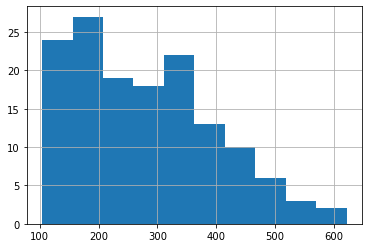

In [52]:
df['Passengers'].hist()

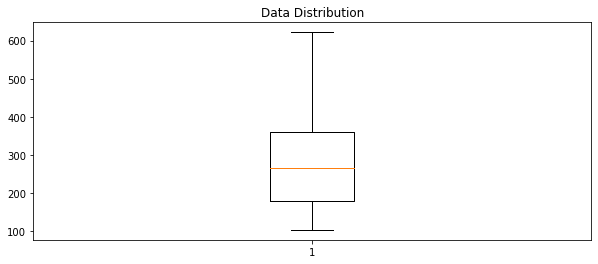

In [53]:
col = df['Passengers']
def get_box_plot(col, x_label=""):
        # Get the variable to examine

    # Create a Figure
    fig = plt.figure(figsize=(10,4))

    # Plot a histogram
    plt.boxplot(col)

    plt.xlabel(x_label)

    # Add titles and labels
    plt.title('Data Distribution')

    # Show the figure
    fig.show() 

get_box_plot(col);

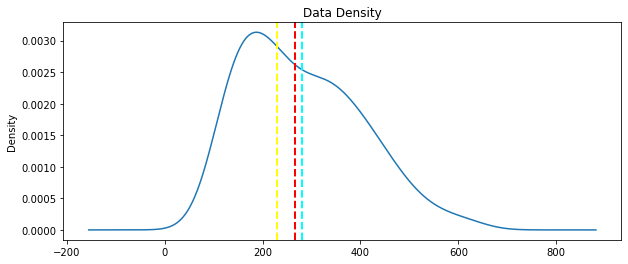

In [54]:
def show_density(col, x_label=""):
    from matplotlib import pyplot as plt

    fig = plt.figure(figsize=(10,4))

    # Plot density
    col.plot.density()

    # Add titles and labels
    plt.title('Data Density')
    plt.xlabel(x_label)
    # Show the mean, median, and mode
    plt.axvline(x=col.mean(), color = 'cyan', linestyle='dashed', linewidth = 2)
    plt.axvline(x=col.median(), color = 'red', linestyle='dashed', linewidth = 2)
    plt.axvline(x=col.mode()[0], color = 'yellow', linestyle='dashed', linewidth = 2)

    # Show the figure
    plt.show()

# Get the density of passengers
col = df['Passengers']
show_density(col)

### This above visualizations tell us a little about the trend and seasonality data and only shows the data from the passenger count perspective.But in time series forecasting date plays a very important role.  

### Bringing time alive

In [43]:
dates = pandas.date_range(start='1949-01-01', freq='MS',periods=len(df))

Now we have fully formated date to play with. Let's swap in the values to the dateframe

In [55]:
df['Month'] = dates.month
df['Year'] = dates.year
df['Date'] = dates


In [70]:
df.set_index('Date',inplace=True)

In [71]:
df.head()

,Month,Passengers,Year
Date,,,
1949-01-01,1,112,1949
1949-02-01,2,118,1949
1949-03-01,3,132,1949
1949-04-01,4,129,1949
1949-05-01,5,121,1949


Now can put the data into time perpective using the data

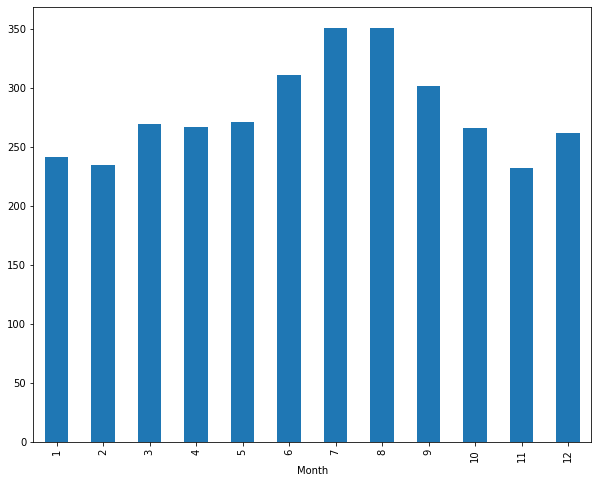

In [58]:
plt.figure(figsize=(10,8))
df.groupby('Month')['Passengers'].mean().plot(kind='bar')
plt.show()

In time series forcasting we are interested in the trend of the data thorugh time. So let's plot a graph that show exactly that.

In [72]:
df['Passengers']

Date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, Length: 144, dtype: int64

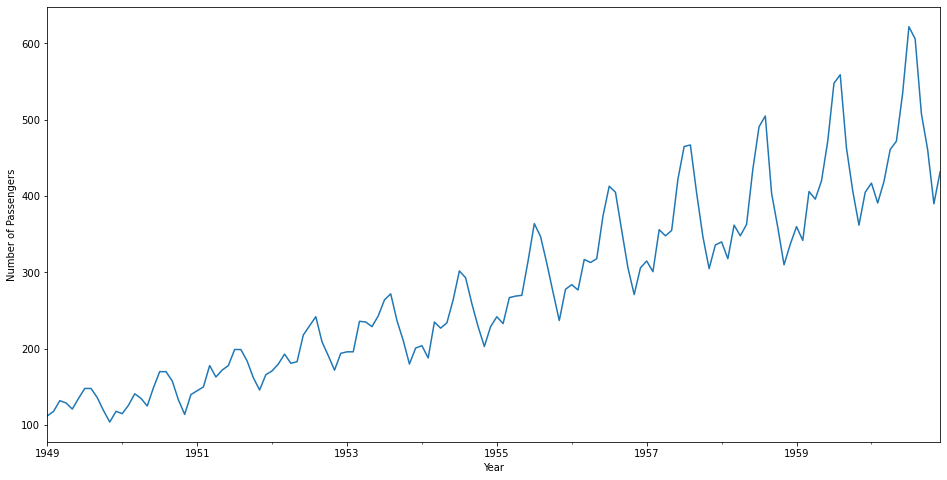

In [73]:
plt.figure(figsize=(16,8))
df['Passengers'].plot()
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

### We can see from the graph that the trend generally increase.Additionally these is somewhat similar trend that the data shows each year. 

## More into the trend of the data using statsmodels api

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

In [95]:
series = df['Passengers']
 = sm.tsa.seasonal_decompose(series,model='multiplicative',extrapolate_trend=8)

Trend -  the trend component at time t, which reflects the long-term progression of the series (secular variation).

Seasonal -  the seasonal component at time t, reflecting seasonality (seasonal variation). A seasonal pattern exists when a time series is influenced by seasonal factors.

Residual - the irregular component (or "noise") at time t, which describes random, irregular influences. It represents the residuals or remainder of the time series after the other components have been removed.

Observed - the actual series

In [104]:
print("Trend:" , result.trend)
print("")
print("")
print("Seasonal:" , result.seasonal)
print("")
print("")
print("Residual: ", result.resid)
print("")
print("")
print("Observed: ",  result.observed)

Trend: Date
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1960-08-01   NaN
1960-09-01   NaN
1960-10-01   NaN
1960-11-01   NaN
1960-12-01   NaN
Name: Passengers, Length: 144, dtype: float64


Seasonal: Date
1949-01-01    0.910230
1949-02-01    0.883625
1949-03-01    1.007366
1949-04-01    0.975906
1949-05-01    0.981378
                ...   
1960-08-01    1.219911
1960-09-01    1.060492
1960-10-01    0.921757
1960-11-01    0.801178
1960-12-01    0.898824
Name: Passengers, Length: 144, dtype: float64


Residual:  Date
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
              ..
1960-08-01   NaN
1960-09-01   NaN
1960-10-01   NaN
1960-11-01   NaN
1960-12-01   NaN
Name: Passengers, Length: 144, dtype: float64


Observed:  Date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-

In [ ]:
fig = decompose.plot()
fig.set_figheight(10)
fig.set_figwidth(8)
fig.suptitle('Passenger count time series decomposed into four components')

The trend of the graph shows that the passenger count increases each year. And the seasonal graph indicates the passenger count show some increase in some months and decrease in some. 

Let's look closer to seasonality of the passenger count interms of months and years.

In [ ]:
monthly = pd.pivot_table(data=df,values='Passengers',index='Month',columns='Year')
monthly = monthly.reindex(index=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

In [ ]:
monthly

References 

1. https://www.sciencedirect.com/science/article/abs/pii/S0926580516301303
2. https://en.wikipedia.org/wiki/Recurrent_neural_network